# Read evaluation and generate tables and bar plots
Goal: reproduce result summaries from the platform to integrate them in the paper.

Note: some submissions did not provide predictions for both datasets, so we could either have 8 tables, or we could have 4 tables with a “left” part for Rumsey and a “right” part for IGN, (blank when an entry skipped one of the evaluations).
Which ranking to use is a bit ambiguous here.

Note: We do not change submission names, to ensure consistency with the online platform.
However, we shorten long submission names with ellipses, like for instance “MapText…Strong Pipeline”.
We apply the same function everywhere to make sure this is consistent across the various tasks.

In [1]:
from icdar24_maptext_analysis.loaders import list_valid_submission_ids, VALID_TASKS, VALID_SUBSETS, load_results
from icdar24_maptext_analysis.submissions_metadata import lookup_generate_title, shorten_title

In [2]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

# original column names to report naming
columns_rename_map = {
    # "char_quality": "Char. Quality (%)",
    # "char_accuracy": "Char. Accuracy (%)",
    "char_quality": "Char. Quality",
    "char_accuracy": "Char. Acc.",
    # "quality": "Det. Quality (%)", 
    "quality": "Det. Quality", 
    # "tightness": "Det. Tightness (%)", 
    "tightness": "Tightness", 
    # "fscore": "Det. FScore (%)", 
    "fscore": "FScore", 
    # "precision": "Det. Precision (%)", 
    "precision": "Precision", 
    # "recall": "Det. Recall (%)",
    "recall": "Recall",
}

subset_rename_map = {
    "rumsey": "Rumsey",
    "ign": "French Land Register",
}

task_extra_description_for_table = {
    1: "isolated word detection",
    2: "grouped word detection",
    3: "word detection with perfect transcription",
    4: "joint grouped word detection and transcription",
}


def generate_all_tables_and_plot(output_dir: str):
    # get the list of valid submission ids
    valid_submission_ids = list_valid_submission_ids()
    # create output directory
    os.makedirs(output_dir, exist_ok=True)
    for task_id in VALID_TASKS:
        for subset in VALID_SUBSETS:
            subset_name = subset_rename_map[subset]
            print()
            print(f"Task {task_id}, \"{subset_name}\" subset")
            print("="*80)
            # read the results
            results_global, _results_per_image = load_results(task_id, subset, filter_fn=lambda x: int(x) in valid_submission_ids)


            # add method names
            results_global["Method name"] = results_global.index.map(lambda idx: lookup_generate_title(int(idx[2])))
            # shorten the titles
            results_global["Method name"] = results_global["Method name"].map(shorten_title)

            # renames columns, sort them and scale their values
            # build the actual renaming map based on the columns present in the results
            columns_rename_map_actual = {k: v for k, v in columns_rename_map.items() if k in results_global.columns}
            results_global.rename(columns=columns_rename_map_actual, inplace=True)
            # get the list of actual columns
            actual_columns = list(columns_rename_map_actual.values())
            # report numbers as 0-100 (percentages) by multiplying by 100
            results_global[actual_columns] *= 100
            # display the results using html rendering
            all_columns = ["Method name"] + actual_columns

            # The sort key is the first columns which actually belongs to columns_rename_map (which is ordered by importance)
            sort_column = [col for col in columns_rename_map.values() if col in actual_columns][0]
            # Add a rank column
            results_global["Rank"] = results_global[sort_column].rank(ascending=False).astype(int)
            all_columns = ["Rank"] + all_columns

            # Display and save the results
            display(results_global[all_columns].sort_values(sort_column, ascending=False))
            # print the results as latex table, using 1 decimal place
            # latex_str = results_global[["Method name", "Quality (%)"]].sort_values(sort_column, ascending=False).to_latex(index=False, float_format="%.1f")
            latex_str = results_global[all_columns].sort_values(sort_column, ascending=False).to_latex(
                index=False,
                float_format="%.1f",
                column_format="cr" + "c" * (len(all_columns) - 2),
                caption=f"Results for task {task_id} ({task_extra_description_for_table[task_id]}) on {subset_name} subset. Values expressed in percentage. For all metrics, higher is better.",
                label=f"tab:task_{task_id}_subset_{subset}",
                position="!ht",
                escape=True,
                )
            # hugly hack to add a resizebox to the table
            latex_str = latex_str.replace(r"\begin{tabular}", r"\resizebox{\textwidth}{!}{\begin{tabular}").replace(r"\end{tabular}", r"\end{tabular}}")
            # print(latex_str)
            # export to file
            with open(os.path.join(output_dir, f"task_{task_id}_subset_{subset}.tex"), "w") as f:
                f.write(latex_str)

            # Increase text size
            plt.rcParams.update({'font.size': 14})
            # plot the results
            results_global[["Method name", sort_column]].sort_values(sort_column, ascending=False).plot.barh(
                x="Method name", y=sort_column, 
                # title=f"Score for task {task_id} on {subset_name} subset", 
                ylabel="", xlabel=sort_column, legend=False, 
                xlim=(0, 100))
            # flip y axis
            plt.gca().invert_yaxis()
            # Adjust layout to ensure labels are not cropped
            plt.tight_layout()
            # export to file
            plt.savefig(os.path.join(output_dir, f"task_{task_id}_subset_{subset}.pdf"), bbox_inches="tight")


Task 1, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
1       rumsey 114579            1  MapText Dete...Strong Pipeline   
               114302            2                        dino_map   
               114279            3                         MapTest   
               114298            4                       dino_mvit   
               114288            5                  MapTextSpotter   
               114197            6                           ensem   
               113478            7       Baseline TESTR Checkpoint   
               113464            8                           DS-LP   
               114534            9           MapText Using EasyOCR   
               114303           10                          MapDet   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
1       rumsey 114579            76.133776  82.747932  92.006863  94.190382   
               114302            73.306749  84.022884  87.246171  87.099592   
               114279            73.092488  81.816676  89.336907  90.470689   
               114298            72.214476  83.582900  86.398625  88.864835   
               114288            70.622195  81.448856  86.707413  92.608510   
               114197            64.161412  85.619384  74.937952  94.147886   
               113478            55.132856  79.567280  69.290865  71.854050   
               113464            53.845988  71.629019  75.173427  71.756203   
               114534            42.672071  73.160727  58.326471  69.290496   
               114303            32.696532  69.231480  47.227840  53.636684   

                                 Recall  
task_id subset submission_id             
1       rumsey 114579         89.922287  
               114302         87.393245  
               114279         88.231191  
               114298         84.065605  
               114288         81.513311  
               114197         62.238757  
               113478         66.904249  
               113464         78.932401  
               114534         50.358162  
               114303         42.187067


Task 1, "French Land Register" subset


Rank                     Method name  \
task_id subset submission_id                                         
1       ign    114298            1                       dino_mvit   
               114302            1                        dino_map   
               114279            3                         MapTest   
               114197            4                           ensem   
               113464            5                           DS-LP   
               114579            6  MapText Dete...Strong Pipeline   
               114303            7                          MapDet   
               113478            8       Baseline TESTR Checkpoint   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
1       ign    114298            64.747268  72.155671  89.732751  88.684322   
               114302            64.747268  72.155671  89.732751  88.684322   
               114279            64.215021  69.865743  91.912028  90.825428   
               114197            51.791168  71.425191  72.511067  90.313514   
               113464            44.081565  65.032914  67.783469  64.847682   
               114579            42.330519  69.285379  61.095890  82.511100   
               114303            35.734407  65.326240  54.701460  70.129281   
               113478            20.564729  70.456698  29.187756  86.376605   

                                 Recall  
task_id subset submission_id             
1       ign    114298         90.806265  
               114302         90.806265  
               114279         93.024942  
               114197         60.571346  
               113464         70.997680  
               114579         48.506381  
               114303         44.837587  
               113478         17.560905


Task 2, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
2       rumsey 114549            1                         MapTest   
               114581            2  MapText Dete...Strong Pipeline   
               113480            3       Baseline TESTR Checkpoint   
               113462            4                           DS-LP   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
2       rumsey 114549            41.938073  74.424610  56.349738  44.157701   
               114581            41.547450  75.435304  55.076930  43.242702   
               113480            35.467885  75.002577  47.288889  37.770408   
               113462            35.039506  69.733378  50.247825  39.388670   

                                 Recall  
task_id subset submission_id             
2       rumsey 114549         77.842114  
               114581         75.829066  
               113480         63.221196  
               113462         69.373594


Task 2, "French Land Register" subset


Rank                     Method name  \
task_id subset submission_id                                         
2       ign    114549            1                         MapTest   
               113462            2                           DS-LP   
               114581            3  MapText Dete...Strong Pipeline   
               113480            4       Baseline TESTR Checkpoint   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
2       ign    114549            59.761955  68.594762  87.123205  83.670228   
               113462            43.302900  64.892009  66.730712  63.102725   
               114581            30.652151  68.767016  44.573914  44.165640   
               113480            14.586178  68.728094  21.223022  58.706468   

                                 Recall  
task_id subset submission_id             
2       ign    114549         90.873451  
               113462         70.801317  
               114581         44.989807  
               113480         12.952799


Task 3, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
3       rumsey 114582            1  MapText Dete...Strong Pipeline   
               114283            2                         MapTest   
               114293            3                  MapTextSpotter   
               113461            4                           DS-LP   
               113479            5       Baseline TESTR Checkpoint   
               114536            6  Recognition ...uned from TrOCR   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
3       rumsey 114582            60.053320  84.205190  71.317837  75.996965   
               114283            52.323040  83.751445  62.474193  63.267645   
               114293            41.091028  82.834901  49.605936  52.981996   
               113461            37.905766  72.546648  52.250196  49.875206   
               113479            27.818012  84.561493  32.896784  34.114201   
               114536            12.194687  78.482212  15.538154  18.459361   

                                 Recall  
task_id subset submission_id             
3       rumsey 114582         67.181478  
               114283         61.700396  
               114293         46.634353  
               113461         54.862682  
               113479         31.763265  
               114536         13.415190


Task 3, "French Land Register" subset


Rank                     Method name  \
task_id subset submission_id                                         
3       ign    114283            1                         MapTest   
               113461            2                           DS-LP   
               114582            3  MapText Dete...Strong Pipeline   
               113479            4       Baseline TESTR Checkpoint   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
3       ign    114283            40.060581  70.713916  56.651623  55.981877   
               113461            26.061912  65.659292  39.692648  37.973510   
               114582             8.647516  70.982234  12.182648  16.452886   
               113479             2.178939  74.714195   2.916365   8.630528   

                                 Recall  
task_id subset submission_id             
3       ign    114283         57.337587  
               113461         41.574826  
               114582          9.672274  
               113479          1.754640


Task 4, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
4       rumsey 114585            1  MapText Dete...Strong Pipeline   
               114551            2                         MapTest   
               113460            3                           DS-LP   
               113481            4       Baseline TESTR Checkpoint   

                              Char. Quality  Char. Acc.  Det. Quality  \
task_id subset submission_id                                            
4       rumsey 114585             33.098815   79.673658     41.542984   
               114551             31.999954   76.302975     41.938017   
               113460             28.570264   81.542959     35.037070   
               113481             26.243398   74.008908     35.459783   

                              Tightness     FScore  Precision     Recall  
task_id subset submission_id                                              
4       rumsey 114585         75.427196  55.076930  43.242702  75.829066  
               114551         74.424510  56.349738  44.157701  77.842114  
               113460         69.728531  50.247825  39.388670  69.373594  
               113481         74.985444  47.288889  37.770408  63.221196


Task 4, "French Land Register" subset


Rank                     Method name  \
task_id subset submission_id                                         
4       ign    114551            1                         MapTest   
               113460            2                           DS-LP   
               114585            3  MapText Dete...Strong Pipeline   
               113481            4       Baseline TESTR Checkpoint   

                              Char. Quality  Char. Acc.  Det. Quality  \
task_id subset submission_id                                            
4       ign    114551             50.965097   85.280170     59.761955   
               113460             37.084092   85.638820     43.302900   
               114585             17.079706   55.728817     30.647888   
               113481              6.046882   41.456245     14.586178   

                              Tightness     FScore  Precision     Recall  
task_id subset submission_id                                              
4       ign    114551         68.594762  87.123205  83.670228  90.873451  
               113460         64.892009  66.730712  63.102725  70.801317  
               114585         68.757453  44.573914  44.165640  44.989807  
               113481         68.728094  21.223022  58.706468  12.952799

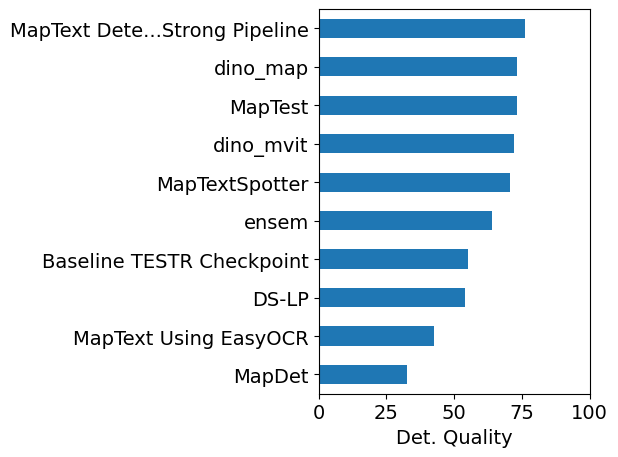

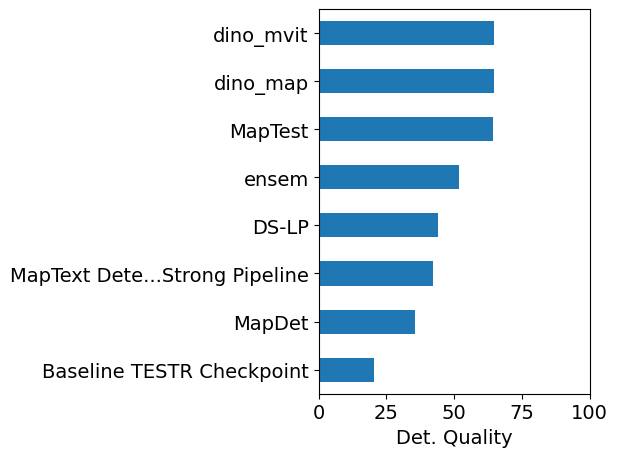

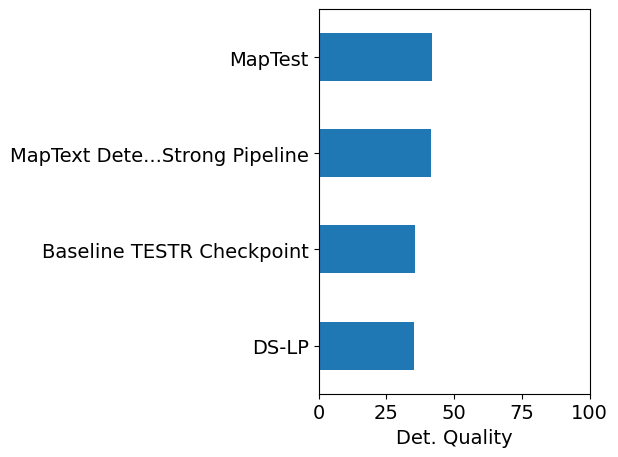

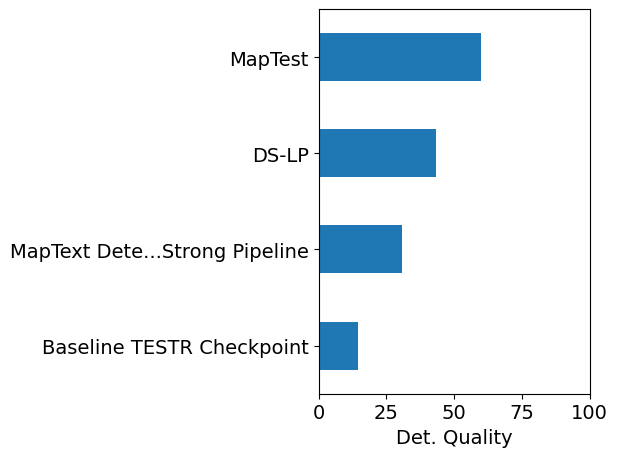

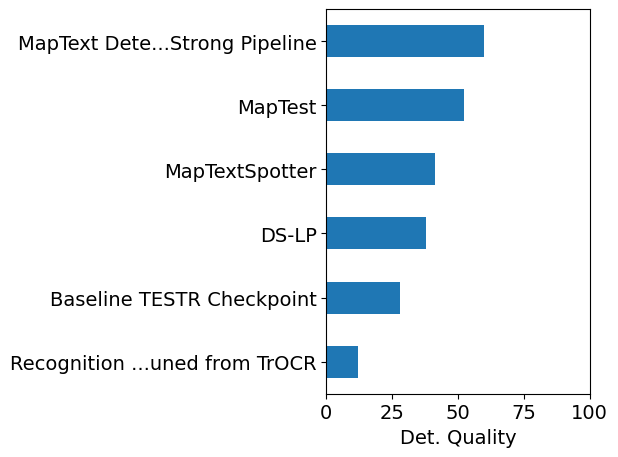

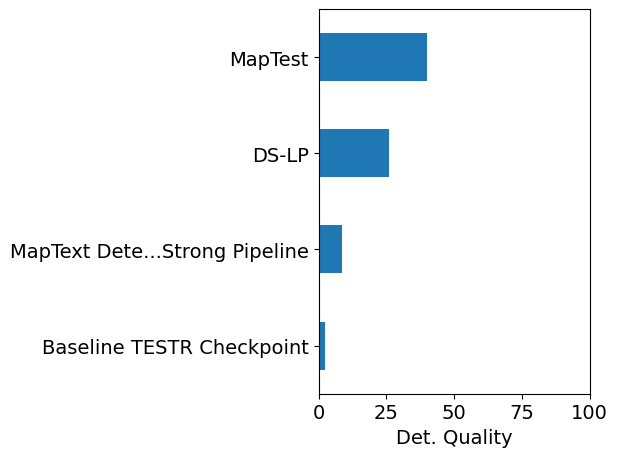

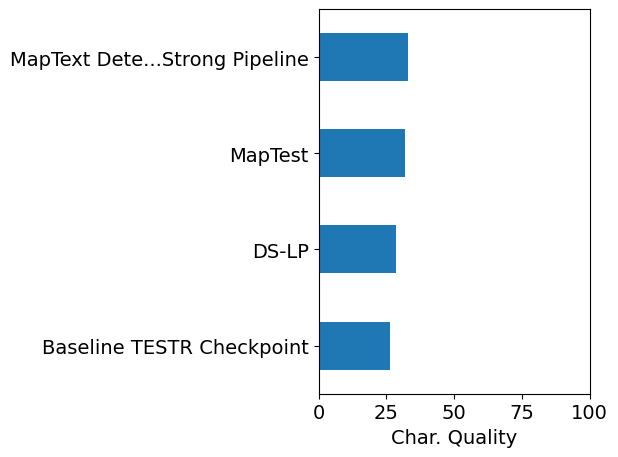

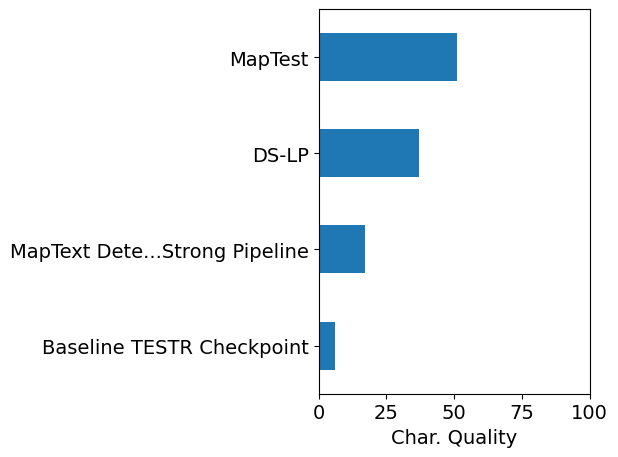

In [3]:
generate_all_tables_and_plot("data/10-tables-and-plots/")